In [144]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import time
import pandas as pd
import os
import shapely 

from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon, MultiPoint, box
from shapely import affinity
from shapely.ops import split, snap, linemerge, nearest_points
from itertools import combinations
from random import randint

In [5]:
cdir = os.getcwd() 
path = os.path.dirname(cdir) + "/geojson_polygons"

glasgow = gpd.read_file(f"{path}/glasgow.geojson").to_crs(3857)#.buffer(3000,join_style=2).to_crs(4326))
glasgow_pd = gpd.read_file(f"{path}/glasgow_polling_districts.geojson").to_crs(3857)

print(glasgow.area)

0    5.586219e+08
dtype: float64


In [32]:
def n_buffer(n, poly):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = Point([poly.centroid.x, poly.centroid.y+poly_r])
    vertices = [a]
    for i in range(n):
        vertices.append(affinity.rotate(a, (360/n)*(i+1), origin=poly_c))
    print("vertices:", vertices)
    return gpd.GeoSeries(Polygon(vertices))

def n_buffer_lines(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0]) * 0.75
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+poly_r]), rot, origin=poly_c)
    lines = [LineString([poly_c,[a.x, a.y]])]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))
    print("lines:", lines)
    return gpd.GeoSeries(lines)

def n_radial(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    buffer = poly.centroid.buffer(poly_r/2)
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+(poly_r*1.2)]), rot, origin=poly_c)
    lines = [LineString([poly_c,[a.x, a.y]])]
    vertices = [a]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        vertices.append(vert_rotate)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))

    return gpd.GeoDataFrame({'geometry' : lines}, geometry='geometry', crs=3857)

glasgow_r = (glasgow.bounds.maxx[0] - glasgow.bounds.minx[0])/2
glasgow_c = (glasgow.centroid.x[0], glasgow.centroid.y[0])
c = Point([glasgow.centroid.x, glasgow.centroid.y+glasgow_r])

minx, miny, maxx, maxy = glasgow.total_bounds
glasgow_bbox = gpd.GeoSeries(box(minx, miny, maxx, maxy, ccw=True))

buff = glasgow_bbox.centroid.buffer(glasgow_r,cap_style = 3)[0]

buff_n = 50
buff_list = [glasgow_bbox.centroid.buffer(glasgow_r * (1 - i*(1/buff_n)), cap_style = 3)[0] for i in range(buff_n)]
buff_gdf = gpd.GeoDataFrame({'geometry':buff_list}, crs=3857)

<Axes: >

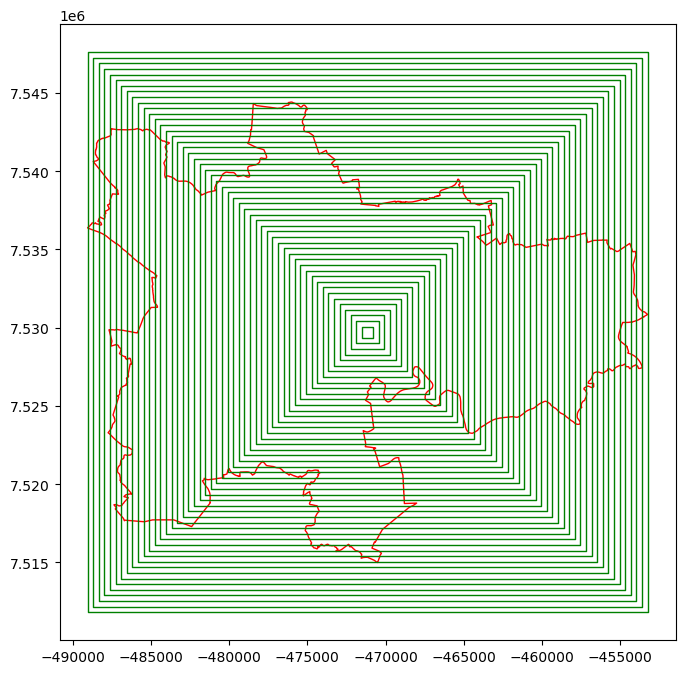

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

glasgow.plot(ax=ax, edgecolor='red', facecolor='none')

buff_gdf.plot(ax=ax, edgecolor='green', facecolor='none')

In [211]:
def square_origin(origin, side):
    #z = np.sqrt(area)/2
    z = side/2
    ox, oy = origin.x, origin.y
    return Polygon([(ox-z,oy-z),(ox-z,oy+z), (ox+z, oy+z), (ox+z, oy-z)])

def get_shape_bounds(shape):
    if isinstance(shape, gpd.geodataframe.GeoDataFrame) or isinstance(shape, gpd.geoseries.GeoSeries):
        return shape.total_bounds
    else:
        return shape.bounds

def get_bounds_angle(shape):
    minx, miny, maxx, maxy = get_shape_bounds(shape)
    ox, oy = shape.centroid.x, shape.centroid.y
    w = maxx - minx
    h = maxy - miny

    bb_poly = Polygon([(minx,miny),(minx, maxy),(maxx, maxy),(minx, maxy)])

    points_list = [shapely.Point(x) for x in bb_poly.boundary.coords]
    points_list = points_list[:-1]

    point_a = points_list[0]
    point_b = points_list[2]

    dist = point_a.distance(point_b)

    theta = np.arcsin(h/dist)
    return theta * 180/np.pi

def tile_squares(shape, side, angle):
    ox, oy = shape.centroid.x, shape.centroid.y
    minx, miny, maxx, maxy = get_shape_bounds(shape.rotate(angle, origin=Point([ox,oy])))
    w = maxx - minx
    h = maxy - miny

    ratio = w/h

    # if ratio > 1: wider than tall
    # if ratio <1 : taller than wide
    x_ratio = y_ratio = (ratio + 2)

    if ratio > 1:
        x_ratio /= 2
    else:
        y_ratio /= 2

    grid_x = int(x_ratio * np.ceil(w/side)) + 1
    grid_y = int(y_ratio * np.ceil(h/side)) + 1

    w_offset = abs(w - (side * grid_x))
    h_offset = abs(h - (side * grid_y))

    x = ox - (w/2 + w_offset/2) + side/2
    y = oy - (h/2 + h_offset/2) + side/2

    square_list = []
    x_list = []
    y_list = []
    for i in range(grid_x):
        for j in range(grid_y):
            origin = Point([x + (i*side), y + (j*side)])
            square_list.append(square_origin(origin, side))

    squares = gpd.GeoDataFrame({'geometry':square_list},crs=shape.crs)
    #squares = gpd.GeoDataFrame(pd.DataFrame(square_list, columns=['geometry']), geometry='geometry')
    #squares_rotate = gpd.GeoDataFrame(geometry=squares.rotate(angle, origin=Point([ox,oy])), crs=shape.crs) 
    squares['geometry'] = squares.apply(lambda gdf: affinity.rotate(gdf.loc['geometry'], angle, 'center'), axis=1)
    #squares['geometry'] = squares.apply(lambda row: row.geometry.rotate(angle, origin=Point([ox,oy])),axis=1)
    return shape.overlay(squares, how='intersection',keep_geom_type=False)

def tile_gdf(gdf, size, angle):
    gdf_out = gpd.GeoDataFrame({'geometry':[]},crs=3857)
    gdf_list = [gdf.iloc[[x]] for x in range(gdf.shape[0])]
    for x in gdf_list:
        gdf_out = pd.concat([gdf_out,tile_squares(x, size, angle)], ignore_index=True)
    return gdf_out

def random_poly_pair(gdf, prop=0.25):
    len_gdf = len(gdf)
    pair_goal = round(len_gdf*prop)
    pair_count = 0
    iter = 0
    pairs = []
    #for i in range(iter):
    while pair_count < pair_goal:
        i_a, i_b = randint(0,len_gdf-1), randint(0,len_gdf-1)
        while(i_a == i_b):
            i_a, i_b = randint(0,len_gdf), randint(0,len_gdf)
        gdf_pair = gdf.iloc[[i_a, i_b],:]
        a = gdf_pair.geometry.iloc[0]
        b = gdf_pair.geometry.iloc[1]
        if(a.intersects(b)):
            pairs.append(gdf_pair.unary_union)
            pair_count += 1
        iter += 1
    print(f"{pair_count} pairs joined in {iter} iterations.")
    return gpd.GeoDataFrame({'geometry':pairs},crs=3857)

glasgow_grid = tile_gdf(glasgow, 2000, 0)

<Axes: >

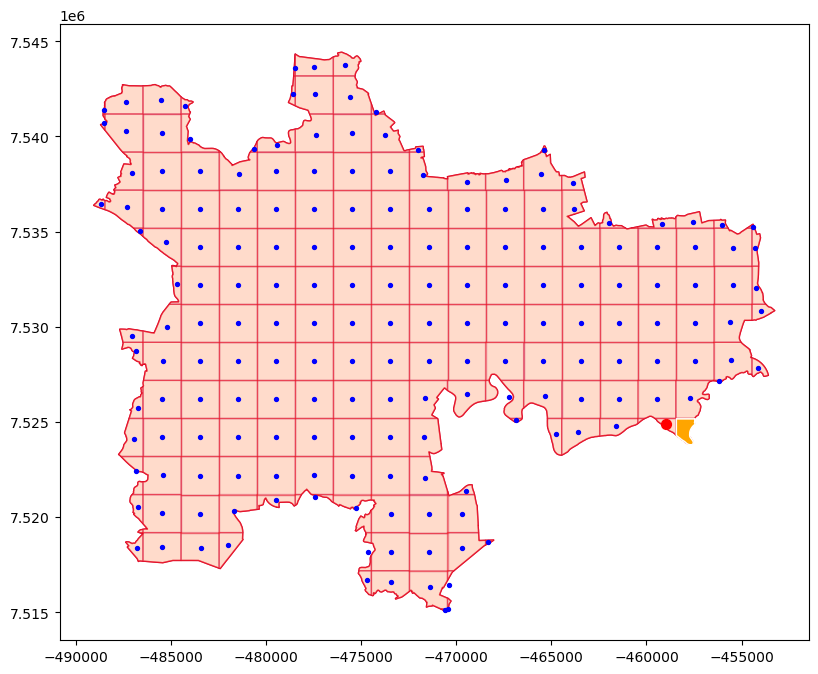

In [221]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

glasgow.plot(ax=ax, edgecolor='red', facecolor='none')

glasgow_grid.plot(ax=ax, edgecolor='blue', facecolor='orange', alpha=0.2)

grid_sample = glasgow_grid.sample(1)

sans_grid_sample = glasgow_grid.centroid[~glasgow_grid.index.isin([grid_sample.index[0]])].geometry

multipoints = MultiPoint([geom for geom in sans_grid_sample.geometry])

sample_nn = nearest_points(grid_sample.geometry, multipoints)[1].set_crs(3857)

glasgow_grid.plot(ax=ax, facecolor='pink', edgecolor='red', alpha=0.4)
grid_sample.plot(ax=ax, edgecolor='white', facecolor='orange')
glasgow_grid.iloc[[sample_nn.index[0]]].plot(ax=ax, edgecolor='white', facecolor='orange')
sans_grid_sample.plot(ax=ax, color='blue', markersize=8)
sample_nn.plot(ax=ax, color='red', markersize=50)

In [62]:
def get_poly_radius(polygon):
    polygon = gpd.GeoSeries(polygon)
    radius = (polygon.bounds.maxx[0] - polygon.bounds.minx[0])/2
    return radius

def random_poly_pair(gdf, prop=0.25):
    len_gdf = len(gdf)
    pair_goal = round(len_gdf*prop)
    pair_count = 0
    iter = 0
    pairs = []
    #for i in range(iter):
    while pair_count < pair_goal:
        i_a, i_b = randint(0,len_gdf-1), randint(0,len_gdf-1)
        while(i_a == i_b):
            i_a, i_b = randint(0,len_gdf), randint(0,len_gdf)
        gdf_pair = gdf.iloc[[i_a, i_b],:]
        a = gdf_pair.geometry.iloc[0]
        b = gdf_pair.geometry.iloc[1]
        if(a.intersects(b)):
            pairs.append(gdf_pair.unary_union)
            pair_count += 1
        iter += 1
    print(f"{pair_count} pairs joined in {iter} iterations.")
    return gpd.GeoDataFrame({'geometry':pairs},crs=3857)

def gdf_radials(gdf, max_n, max_rot, buffers):
    gdf_out = gpd.GeoDataFrame({'geometry':[]}, crs=3857)
    gdf_area = gdf.unary_union.area
    for polygon in gdf.geometry:
        buffers_current = round((polygon.area / gdf_area)*100 * buffers)
        gdf_current, _ = radial_split(polygon, max_n, max_rot, buffers_current)
        polygons_all = [[poly for poly in multi.geoms] for multi in gdf_current.geometry]
        gdf_current_flat = gpd.GeoDataFrame({'geometry':[val for sublist in polygons_all for val in sublist]}, crs=3857)
        gdf_current = gdf_current_flat.clip(polygon)
        gdf_out = pd.concat([gdf_out, gdf_current])
    return gdf_out

test = gdf_radials(glasgow_pd, 10, 10, 10)

small_inner, small_buffers = radial_split(glasgow.geometry[0], 10, 10, 20) 
small_inner = small_buffers.iloc[[-1]]
small_pds = glasgow_pd.sjoin(small_inner)


0      POLYGON ((-483601.907 7537861.085, -483626.111...
1      POLYGON ((-470852.094 7519375.792, -470934.054...
2      POLYGON ((-474713.986 7519096.586, -474737.046...
3      POLYGON ((-480208.002 7526815.777, -480208.238...
4      POLYGON ((-470600.243 7530849.116, -470587.816...
                             ...                        
259    POLYGON ((-468060.180 7530174.942, -468081.082...
260    POLYGON ((-472177.039 7533022.076, -472194.076...
261    POLYGON ((-472856.496 7532593.323, -472888.265...
262    POLYGON ((-472783.793 7531181.794, -472840.309...
263    POLYGON ((-484813.468 7527781.169, -484816.860...
Name: geometry, Length: 264, dtype: geometry
test                                              geometry
12  POLYGON ((-483473.967 7536300.479, -483409.998...
11  POLYGON ((-483368.193 7536355.791, -483349.302...
5   POLYGON ((-483113.978 7536626.754, -483150.358...
0   POLYGON ((-483391.109 7536931.328, -483396.301...
10  POLYGON ((-483081.601 7536696.652, -483059.884...

<Axes: >

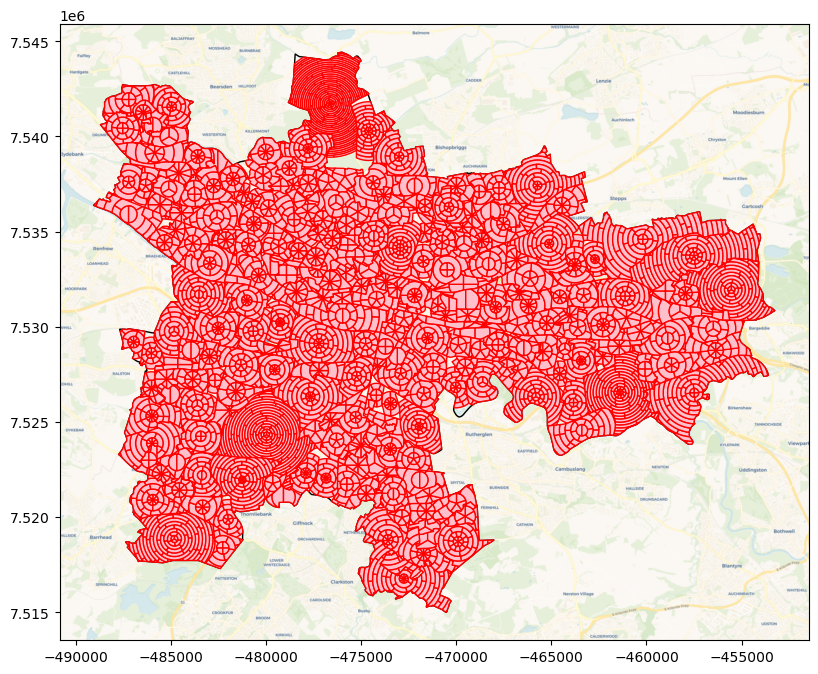

In [63]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

glasgow.plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

print(glasgow_pd.geometry)
print("test", test)

test.plot(ax=ax, edgecolor='red', facecolor='pink')

#paired_polys = random_poly_pair(test,0.4)

#paired_polys.plot(ax=ax, facecolor='purple', edgecolor='black')